<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 31 January 2017</td>
<td style="text-align: right;"><a href="https://www.github.com/rhyswhitley/fire_limitation">github.com/rhyswhitley/fire_limitation</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of a global fire limitation model using Bayesian inference</h1>
<h2>Part 2: Bayesian inference</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>2 </sup>Ioannis Bistinas,
<sup>3 </sup>Rhys Whitley,
<sup>4 </sup>Chantelle Burton, 
<sup>1 </sup>Tobias Marthews, 
<sup>6, 7 </sup>Ning Dong
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Vrije Universiteit Amsterdam, Faculty of Earth and Life Sciences, Amsterdam, Netherlands
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>4 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>5 </sup>Centre for Past Climate Change and School of Archaeology, Geography and Environmental Sciences (SAGES), University of Reading, Reading, United Kingdom 
<br>
<sup>6 </sup>Department of Biological Sciences, Macquarie University, North Ryde, NSW 2109, Australia 
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of a global fire model (defined below). The model is driven by a number of covariates (X<sub>i=1, 2, ... M</sub>) that describe: cropland, pasture and urban area footprints; frequency of lightening ignitions, population density, vegetation cover and <i>Alpha</i>, a proxy measure of available soil moisture in the root zone. The model attempts to predict the impact of fire through burnt area and is thus the model target (Y).
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### Model description
The model considers percentage of burnt area to be the joint product of a set of conditions that modulate fire through fuel load, ignitions, moisture and supression. Each control assumes some equilibrium point that desribes the optimal conditions for fire, that may be proportionally modified through some empirical relationship. These are briefly outlined below for the sake of comprehension in this notebook, but can be referred to in more detail in the model protocol located in the docs/ folder (<a href='file:///localhost/../docs/Model_description.pdf'>model protocol</a>).

\begin{eqnarray}
    F_{burn} &=& \prod_{i}S(x_{i}) \\[1em]
\end{eqnarray}

Where $S(x_{i})$ representes some measure of fire conditions by $i =$ fuel, moisture, ignitions and anthropagenic supression, and is describe by a sigmoid:

\begin{equation}
    S(x_{i=fuel, moist, ignite, suppr}) = \frac{1}{1 + \exp\{-b\cdot(x_i-a)\}}
\end{equation}

The $fuel$ sigmoid considers only fractional vegetation cover and therefore have no hyper-parameters. Sigmoids $moist$, $ignite$ and $suppr$ describe an aggregation of other climate and land-use covariates. Because these sigmoids are influenced by an aggregation of different drivers, they are influenced in turn by different sets of hyper-parameters; these are now described below.  

#### Fuel load covariate (no hyper-parameters)
\begin{equation}
    x_{fuel} = FPC^{p} \cdot (v_{fuel} \cdot (\alpha_{max}/\alpha -1) + 1)/(1+v_{fuel}) 
\end{equation}

#### Moisture covariate
\begin{equation}
    x_{moist} = \alpha + v_M \cdot EMC    
\end{equation}

where $EMC$ is the equilibrium moisture content.
#### Ignition covariate 
\begin{equation}
    x_{ignite} = Lightn + v_p\cdot A_{pasture} + v_{d1}\cdot\rho_{population}
\end{equation}

Where $Lightn$ is the number of cloud-to-ground lightning strikes, modified  as per Kelley et al. 2014.

#### Supression covariate 
\begin{equation}
    x_{supress} = A_{urban} + v_C\cdot A_{Crop} + v_{d2}\cdot\rho_{population} 
\end{equation}

This leaves 17 free parameters that need to be optimised against observations of burnt area.  

### Load libraries

In [32]:
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import pymc3  as pm3 
from   pymc3.backends import SQLite
from   scipy  import optimize
from   theano import tensor as tt

import matplotlib.pyplot as plt

# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

# paths and parameters
                    # Full model
sample_pc     = 100 # = 100 # Percentage of grid cells samples (largest = 100%) - training set
nIterations   = 10000 # = 10000 # no. times it samples the posterior
nJobs         = 1   # = 1 # no. times it runs through optimisation proceedure = sample_pc * nJobs
#chains per job
nChains       = 10  # = 10

datPath       = "../data/amazon_inference_data-TERRA_M__T.csv"
varname       = ["firecount", "firecount", "firecount"]
exponate      = [True, True, True]
errorDists     = ['Tnorm', 'Snorm', 'Lnorm']
param_outpath = '../outputs/params-test_errors-2002'
trace_db      = '../data/firemodel_trace.db'

In [33]:
def npLog0 (x):
    return [np.log(i) if i > 0 else 0.0000001 for i in x]

## 2.1 Fire limitation model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [34]:
from pdb import set_trace as browser
def fuel_load(vegcover, soilwMax, fuel_pw, fuel_pg):
    """
    Definition to describe fuel load: while return the input; capability to be modified later.
    """
  
    return (vegcover**fuel_pw) * (fuel_pg * (soilwMax-1) + 1) / (1 + fuel_pg)

def emc_weighted(emc, precip, wd_pg):
    wet_days = 1 - tt.exp(-wd_pg * precip)
    
    emcw = wet_days + (1-wet_days) * emc
    
    return(emcw)
    
    
def moisture(soilw, emcw, treeCover, precip, cM, cMT, cMP):
    """
    Definition to describe moisture
    """
    return (soilw + cM*emcw + cMT * treeCover + cMP * precip) / (1 + cM + cMT + cMP)


def ignition(lightning, pasture, population_density, cP, cD1):
    """
    Definition for the measure of ignition
    """
    ignite = lightning + cP*pasture + cD1*population_density
    #ignite = tt.log(ignite)
    return ignite

def supression(cropland, population_density, cD2):
    """
    Definition for the measure of fire supression
    """
    return cropland + cD2*population_density

def tt_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + tt.exp(-k*(x - x0)))

## 2.2 Import data

Load data and do any necessary transformation needed for the Bayesian modelling framework. Rows are defined as a fraction of total data points (above). For full optimiatizaion, we set at 10%, but for testing purposes I've limited the number of rows I'm importing to 2%.

In [35]:
def load_with_buffer(filename, line_select, **kwargs):
    s_buf = StringIO()
    line_select = np.sort(line_select)
    with open(filename) as file:
        count = -1
        lineN = -1
        for line in file:
            lineN += 1
            if lineN == 0 or lineN == line_select[count]:
                s_buf.write(line)
                
                count += 1
                if count == len(line_select): break
            
    s_buf.seek(0)
    df = pd.read_csv(s_buf,**kwargs)
    return df

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f): pass
    return i + 1

DATAPATH = os.path.expanduser(datPath)

nlines      = file_len(DATAPATH)
npoints     = round(sample_pc * nlines / 100)
line_select = np.random.choice(range(0, nlines), npoints, False)
line_select = line_select[line_select > 0]
fd          = load_with_buffer(DATAPATH, line_select)


Do a sanity check to make sure our data has imported correctly.

In [36]:
fd.head()

,nonetreecover,treecover,vegcover,MaxOverMean_soilw,cropland,fract_agr,pasture,population_density,dt_cropland,dt_fract_agr,...,dt.1,dt.2,air,emc,lightning,relative_humidity,precip,seasonDiff,soilw,firecount
0,0.566104,0.288708,0.854812,1.279859,0.075360,0.586741,0.511381,55.566036,0.000075,0.005090,...,0.005090,0.005015,27.087145,0.205117,117.581160,69.133930,0.575250,1.003373,0.277269,62.0
1,0.519627,0.299700,0.819326,1.502096,0.084143,0.447438,0.363295,62.798744,0.000132,0.003784,...,0.003784,0.003653,25.412504,0.186246,126.675490,59.910713,0.670358,1.007553,0.064362,97.0
2,0.554406,0.234010,0.788417,1.783515,0.097023,0.220080,0.123057,60.748290,-0.000030,0.000290,...,0.000290,0.000320,26.206789,0.175376,41.093647,56.357143,0.183623,0.977350,0.000000,198.0
3,0.559727,0.243175,0.802903,2.143794,0.062484,0.196809,0.134325,102.104780,-0.000024,0.000885,...,0.000885,0.000909,26.552143,0.181388,1.843172,59.107143,0.547380,0.961316,0.000000,412.0
4,0.562847,0.158067,0.720914,1.937969,0.044306,0.165909,0.121603,44.035473,-0.000038,0.000417,...,0.000417,0.000455,25.338928,0.216764,5.154491,72.044640,0.491154,1.030102,0.067631,82.0


KeyError: 'burnt_area'

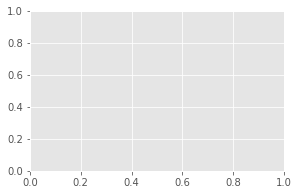

In [38]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.scatter(fd['burnt_area'], fd['firecount'], alpha = 0.1)
plt.subplot(322)
#plt.scatter(fd['precip'], fd['burnt_area'], alpha = 0.1)
plt.subplot(323)
plt.scatter(fd['soilw'], fd['firecount'], alpha = 0.1)
plt.subplot(324)
plt.scatter(fd['vegcover'], fd['firecount'], alpha = 0.1)
plt.subplot(325)
#plt.scatter(fd['cropland'], fd['burnt_area'], alpha = 0.1)
plt.subplot(326)
#plt.scatter(fd['lightning'], fd['burnt_area'], alpha = 0.1)

In [39]:
fd.info()
print(fd.max())
fd.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44750 entries, 0 to 44749
Data columns (total 22 columns):
nonetreecover         44750 non-null float64
treecover             44750 non-null float64
vegcover              44750 non-null float64
MaxOverMean_soilw     44750 non-null float64
cropland              44750 non-null float64
fract_agr             44750 non-null float64
pasture               44750 non-null float64
population_density    44750 non-null float64
dt_cropland           44750 non-null float64
dt_fract_agr          44750 non-null float64
dt_pasture            44750 non-null float64
dt                    44750 non-null float64
dt.1                  44750 non-null float64
dt.2                  44750 non-null float64
air                   44750 non-null float64
emc                   44750 non-null float64
lightning             44750 non-null float64
relative_humidity     44750 non-null float64
precip                44750 non-null float64
seasonDiff            44750 non-null

,nonetreecover,treecover,vegcover,MaxOverMean_soilw,cropland,fract_agr,pasture,population_density,dt_cropland,dt_fract_agr,...,dt.1,dt.2,air,emc,lightning,relative_humidity,precip,seasonDiff,soilw,firecount
0,0.566104,0.288708,0.854812,1.279859,0.075360,0.586741,0.511381,55.566036,0.000075,0.005090,...,0.005090,5.015016e-03,27.087145,0.205117,117.581160,69.133930,0.575250,1.003373,0.277269,62.0
1,0.519627,0.299700,0.819326,1.502096,0.084143,0.447438,0.363295,62.798744,0.000132,0.003784,...,0.003784,3.652811e-03,25.412504,0.186246,126.675490,59.910713,0.670358,1.007553,0.064362,97.0
2,0.554406,0.234010,0.788417,1.783515,0.097023,0.220080,0.123057,60.748290,-0.000030,0.000290,...,0.000290,3.200173e-04,26.206789,0.175376,41.093647,56.357143,0.183623,0.977350,0.000000,198.0
3,0.559727,0.243175,0.802903,2.143794,0.062484,0.196809,0.134325,102.104780,-0.000024,0.000885,...,0.000885,9.089261e-04,26.552143,0.181388,1.843172,59.107143,0.547380,0.961316,0.000000,412.0
4,0.562847,0.158067,0.720914,1.937969,0.044306,0.165909,0.121603,44.035473,-0.000038,0.000417,...,0.000417,4.552454e-04,25.338928,0.216764,5.154491,72.044640,0.491154,1.030102,0.067631,82.0
5,0.476833,0.408024,0.884858,1.062662,0.017306,0.070869,0.053563,17.332075,0.000050,0.001248,...,0.001248,1.198113e-03,25.305716,0.265329,100.561660,91.437500,3.409420,1.194109,0.653138,3.0
6,0.511510,0.403021,0.914531,1.062974,0.049049,0.324843,0.275793,57.179070,0.000166,0.003210,...,0.003210,3.044188e-03,21.976793,0.258696,349.522060,85.455360,1.739765,-1.372211,0.613157,49.0
7,0.549206,0.347227,0.896432,1.193181,0.057812,0.473489,0.415677,54.060883,0.000172,0.004720,...,0.004720,4.547685e-03,22.679646,0.213658,156.334690,68.142860,0.595429,-4.197521,0.381371,67.0
8,0.597786,0.269141,0.866927,1.383104,0.066443,0.229776,0.163333,14.253548,0.000101,0.001876,...,0.001876,1.774400e-03,27.701786,0.170746,46.084488,56.000000,0.184299,-1.096646,0.057995,929.0
9,0.591602,0.240000,0.831602,1.698555,0.041235,0.155881,0.114646,6.767996,0.000029,0.001732,...,0.001732,1.702510e-03,28.437860,0.160914,6.552771,52.803570,0.339156,1.869319,0.000000,998.0


## 2.3 Baysian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the reponse of our _proposed understanding_ of this system as it varies with $X$.

### 2.3.1 Prior definitions
Because I have no idea what the uncertainty on the hyper parameters should look like (beyond $\beta> 0$), I've set them all as uniform, where bounds are either physical limits of the variable in question, or set generously beyound what is realistic plausable. Some of them can possibly be describe as exponential or half-normal, due to the physical nature of $\beta$, but we can play around with that later.

\begin{eqnarray}
    P(\beta) &=& \prod_{i=1}^{4}P(a_i)\prod_{i=1}^{4}P(b_i)\cdot P(\sigma)\cdot P(v_c)P(v_p)P(v_{d,1})P(v_{d,2}) \\[1.5em]
    P(a) = P(b) = P(\sigma) &=& \mathcal{N}(0, 1) \\[1em]
    P(v_c) = P(v_p) = P(v_{d,1}) = P(v_{d,2}) &=& \mathcal{U}(\beta_{\min}, \beta_{\max}) \\[1.5em]
\end{eqnarray}

I'm not totally sure about the maths above being right, but it's just to show that _full_ prior is normal. Important, because we'll also describe the error (likelihood) as normal, such that the posterior is therefore normal (conjugate); i.e. $\mathcal{N}\times\mathcal{N}=\mathcal{N}$ (expansion happens in the mean of the exponent). 

Back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `fire_error` as that is what we are trying to Quantify.



### 2.3.2 Likelihood definition

For the sake of simplicity (and because I don't really know any better), we define the model error as normally distributed (i.i.d.) although it most likely isn't. We could make this more complicated later by defining the error as heteroscedastic, but I wouldn't bother with that until we have some idea of the convergence. We're describing the error (observations minus model predictions) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(F_{burn}, \sigma) \\[1em]
    \mathcal{N}(F_{burn}, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - F_{burn, i}}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $y_i$ is a set of observations we're attempting to optimise on. Below is the code that describes the above:

### 2.3.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out - but TBH it doesn't matter if we're getting a reasonable convergence.

In [40]:
nChains = nChains* nJobs

def runOptimiezationOnVar(variable, exponate, errorDist):
    obs = fd[variable].values
    #obs = np.log(fd[variable].values)
    if errorDist == "Lnorm":
        obs = np.clip(obs, 0.000001, 10000000000)
    with pm3.Model() as fire_error:

    # first for the sigmoids  
        fuel_x0        = pm3.Normal     ('fuel_x0'     , 0.5, 0.25)
        fuel_k         = pm3.Exponential('fuel_k'      , 1.0     ) 
        fuel_pw        = pm3.Exponential('fuel_pw'     , 1.0)
        fuel_pg        = pm3.Uniform('fuel_pg'         , 0.0, 1.0)

        moisture_x0    = pm3.Normal     ('moisture_x0', 0.5, 0.25)
        moisture_k     = pm3.Exponential('moisture_k'  , 1.0     )
        wd_pg          = pm3.Exponential('wd_pg'  , 1.0     )

        ignition_x0    = pm3.Normal     ('ignition_x0', 1000.0, 50.0)
        ignition_k     = pm3.Exponential('ignition_k' , 100.0     )

        suppression_x0 = pm3.Normal ('suppression_x0'  , 0.5, 0.25)
        suppression_k  = pm3.Exponential('suppression_k', 1.0     ) 

        max_f          = pm3.Uniform('max_f'           , 0.0, 1.0)
        exp_scale      = pm3.Exponential('exp_scale'   , 1.0     )
        
        #pow_f          = pm3.Uniform('pow_f'         ,     0.0,    1.0)
    # now for the hyper-parameters that describe the independent fire condition covariates
        cM  = pm3.Exponential('cM' , 1.0)
        cMT = pm3.Exponential('cMT', 1.0)
        cMP = pm3.Exponential('cMP', 1.0)
        #cL  = pm3.Uniform('cL' , 0, 1e4)
        cP  = pm3.Exponential('cP' , 1.0)
        cD1 = pm3.Exponential('cD1', 1.0)
        cD2 = pm3.Exponential('cD2', 1.0)

        #cDmax = pm3.Uniform('cDmax', 0, 1e4)
    # describe the standard deviation in the error term
        sigma = pm3.HalfNormal('sigma', sd=1)
        if errorDist == "Snorm": alpha_skew =  pm3.Normal ('alpha_skew'  , 0.0, 1.0)

        # transform hyper-covariates 
        f_fuel        = fuel_load(fd["vegcover"].values, fd["MaxOverMean_soilw"].values, fuel_pw + 1.0, fuel_pg)
        
        emc_w         = emc_weighted(fd["emc"].values, fd["precip"].values, wd_pg)

        f_moisture    = moisture(fd["soilw"].values, emc_w, fd["treecover"].values, fd["precip"].values, cM, cMT, cMP)

        f_ignition    = ignition(fd["lightning"].values, \
                                 fd["pasture"].values, \
                                 fd["population_density"].values, \
                                 cP, cD1)
        #f_ignition   = np.log(f_ignition)
        f_suppression = supression(fd["cropland"].values, \
                                   fd["population_density"].values, \
                                   cD2)

        # burnt area is assumed to be the product of the 4 sigmoids

        prediction = max_f * np.product([tt_sigmoid(f_fuel, fuel_k, fuel_x0),
                                 tt_sigmoid(f_moisture, - moisture_k, moisture_x0),
                                 tt_sigmoid(f_ignition, ignition_k, ignition_x0),
                                 tt_sigmoid(f_suppression, - suppression_k, suppression_x0)])
        
        
        if exponate:
            prediction  = -(1.0/exp_scale) * tt.log(1.0 - prediction)
            #prediction = tt.clip(prediction, 0.000001, 10000000000)
            #alpha = prediction * sigma + 1.0
            #error = pm3.Lognormal('error', mu=prediction, sd=sigma, observed=obs)
            if errorDist == "Tnorm":
                error = pm3.TruncatedNormal('error', mu=prediction, sd=sigma, observed=obs, lower = 0.0)
            elif errorDist == "Lnorm":
                prediction = tt.clip(prediction, 0.000001, 10000000000)
                error = pm3.Lognormal('error', mu=prediction, sd=sigma, observed=obs)
            elif errorDist == "Snorm":
                error = pm3.SkewNormal('error', mu=prediction, sd=sigma, alpha = alpha_skew, observed=obs)
        else:
            error = pm3.TruncatedNormal('error', mu=prediction, sd=sigma, observed=obs, lower = 0.0, upper = 1.0)
        
        #prediction = tt.log(prediction)
        #prediction = tt.clip(prediction, -10, 10000000000)
        # calculate the error between observed and predicted burnt area
        
        # help the sampling out by quickly finding an optimal start position
        #start = pm3.find_MAP(draws = 10000, model=fire_error.model, fmin=optimize.fmin_powell)

        # set the step-method (criteria algorithm for moving around information space)
        
        step = pm3.Metropolis()

        # save our sampling to disk so we can access it later
        #db_save = SQLite(trace_db)

        # do the sampling
        mcmc_traces = pm3.sample(nIterations, step=step, chains = nChains) #, start=start
    return(mcmc_traces)

In [41]:
outputs = [runOptimiezationOnVar(v, e, d) for v, e, d in zip(varname, exponate, errorDists)]

#out0 = runOptimiezationOnVar(varname[0], exponate[0])
#out1 = runOptimiezationOnVar(varname[1], exponate[1])

Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [cD2]
>Metropolis: [cD1]
>Metropolis: [cP]
>Metropolis: [cMP]
>Metropolis: [cMT]
>Metropolis: [cM]
>Metropolis: [exp_scale]
>Metropolis: [max_f]
>Metropolis: [suppression_k]
>Metropolis: [suppression_x0]
>Metropolis: [ignition_k]
>Metropolis: [ignition_x0]
>Metropolis: [wd_pg]
>Metropolis: [moisture_k]
>Metropolis: [moisture_x0]
>Metropolis: [fuel_pg]
>Metropolis: [fuel_pw]
>Metropolis: [fuel_k]
>Metropolis: [fuel_x0]
Sampling 10 chains: 100%|██████████| 105000/105000 [7:42:03<00:00,  1.12draws/s]  
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha_skew]
>Metropolis: [sigma]
>Metropolis: [cD2]
>Metropolis: [cD1]
>Metropolis: [cP]
>Metropolis: [cMP]
>Metropolis: [cMT]
>Metropolis: [cM]
>Metropo

In [42]:
#outputs = [out0, out1]
#for mcmc_traces in outputs: pm3.traceplot(mcmc_traces);
#pm3.traceplot(out0)

## Output paramaters
The iterations at the start are just letting the optimization settle. So we will only sample to last 50% of iterations for futher analysis. We also expor these to csv, which others can use to do their own analysis.

In [43]:
def output_vals(mcmc_traces, v, d):
    varnames = mcmc_traces.varnames
    def cutLastX(varname, mcmc_traces, ncut = 50):
        vals = mcmc_traces.get_values(varname)
        def subcut(vals, r, ncut = 50):
            cut_np = (r+1) * round(len(vals)/nChains)
            ncut = round(len(vals) * ncut / (nChains *100))
            return vals[(cut_np - ncut):cut_np]
        vals = [subcut(vals, r) for r in range(nChains)]
        return np.array(vals).flatten()

    vals = [cutLastX(i, mcmc_traces) for i in varnames]
    vals = pd.DataFrame(np.array(vals).T, columns=varnames)
    param_outpathi = param_outpath + d + '-' + v + '.csv'
    print(param_outpathi)
    vals.to_csv(param_outpathi, index=False)
    return(vals)
    
valss = [output_vals(mcmc_traces, v, d) for mcmc_traces, v, d in zip(outputs, varname, errorDists)]

../outputs/params-test_errors-2002Tnorm-firecount.csv
../outputs/params-test_errors-2002Snorm-firecount.csv
../outputs/params-test_errors-2002Lnorm-firecount.csv


## Plotting

Let look at the pdf of the last 50% of iterations for each parameter

In [ ]:
variables2Plot = ['fuel_x0'       , 'fuel_k',
                  'moisture_x0'   , 'moisture_k',
                  'ignition_x0'  , 'ignition_k',
                  'suppression_x0', 'suppression_k',
                  'fuel_pw'       , 'fuel_pg',
                  'cM'            , 'cMT',
                  'cP',
                  'cD1'           , 'cD2',
                  'exp_scale'     , 'max_f',
                  'sigma']

nvar = len(variables2Plot)
npcol = 4
nprow = np.ceil(nvar / npcol)


def plotVar(var1, pn, vals):
    plt.subplot(npcol, nprow, pn)
    param = vals[var1]
    
    hist, bins = np.histogram(param, bins=50)
    hist = 100.0 * hist / np.sum(hist)
    bins = bins[1:] - np.diff(bins)/2
    plt.plot(bins, hist)
    plt.xlabel(var1)

for vals in valss:
    plt.figure(figsize=(20,5 * nprow))
    pn = 0
    for i in variables2Plot:
        pn = pn + 1
        plotVar(i, pn, vals)

And what to the sigmoids look like?

In [ ]:
from pdb import set_trace as browser

def pltVsFire(x, xlab, pnt = 'o', *args, **kw):
    plt.plot(x, fd.burnt_area, pnt, alpha = 0.03, *args, **kw)
    plt.xlabel(xlab)
    
def np_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + np.exp(-k*(x - x0)))

def returnSigmoid(x, k, x0):
    return np_sigmoid(x, k, x0)
    
def meanParam(x, x0, k, kmult = 1.0, vals = valss[0]):
    x0 = np.mean(vals[x0])
    k  = np.mean(vals[k]) * kmult

    return returnSigmoid(x, k, x0)

def randomParam(x, x0, k, kmult = 1.0, size = 100, vals = valss[0]):
    ps = np.random.choice(vals.shape[0], size = size, replace = False)
    return [returnSigmoid(x, vals[k][i] * kmult, vals[x0][i])* vals['max_f'][i] for i in ps]

In [ ]:


for vals in valss:
    plt.figure(figsize=(10, 10))
    ####################
    ## Fuel           ##
    ####################
    plt.subplot(2, 2, 1)
    ## scatter plot
    fp = np.mean(vals['fuel_pw'])
    fg = np.mean(vals['fuel_pg'])

    f_fuel = fuel_load(fd["vegcover"].values, fd["MaxOverMean_soilw"].values, fp, fg)
    print(f_fuel.max())
    pltVsFire(f_fuel, "Fuel continuity", 'go')

    ## Line of best fit
    Fuel = np.arange(0, f_fuel.max(), 0.01)
    r_fuel = randomParam(Fuel, 'fuel_x0', 'fuel_k', vals = vals)
    for r in r_fuel: plt.plot(Fuel, r, 'k', alpha=.01)

    ####################
    ## Moisture       ##
    ####################
    plt.subplot(2, 2, 2)
    ## scatter plot
    cM = np.mean(vals['cM'])
    cMT = np.mean(vals['cMT'])
    cMP = np.mean(vals['cMP'])
    f_moisture = moisture(fd["soilw"].values, fd["emc"].values, fd["precip"].values, fd["treecover"].values,
                          cM, cMT, cMP)
    pltVsFire(f_moisture , "Moisture = $\\alpha$ + M $\cdot$ EMC",'bo')

    ## Line of best fit
    mst = np.arange(0.0, f_moisture.max(), 0.05)
    r_moisture = randomParam(mst, 'moisture_x0', 'moisture_k', -1, vals = vals)
    for r in r_moisture: plt.plot(mst, r, 'k', alpha=.1)


    ####################
    ## Ignitions       ##
    ####################
    plt.subplot(2, 2, 3)
    ## scatter plot 
    cP  = np.mean(vals['cP' ])
    cD1 = np.mean(vals['cD1'])
    igniteMax = 5000

    f_ignite = ignition(fd["lightning"].values, \
                        fd["pasture"].values, \
                        fd["population_density"].values, \
                        cP, cD1)

    pltVsFire(f_ignite, "Ignitions events = Lightn + P $\cdot$ Pop Dens + D1 $\cdot$ Pasture")

    ## Line of best fit
    Ignite = np.arange(0.0, igniteMax, 0.1)
    r_Ignite = randomParam(Ignite, 'ignition_x0', 'ignition_k', vals = vals)
    for r in r_Ignite: plt.plot(Ignite, r, 'k', alpha=.01)

    plt.xlim(0, 500)

    ####################
    ## Suppression    ##
    ####################
    plt.subplot(2, 2, 4)
    #scatter plot
    cD2 = np.mean(vals['cD2'])
    f_suppression = supression(fd["cropland"].values, \
                               fd["population_density"].values, \
                               cD2)

    pltVsFire(f_suppression, "Suppression = Cropland + D2 $\cdot$ Pop den")

    # Line of best fit
    Suppress = np.arange(0, 100, 0.01)
    r_suppression = randomParam(Suppress, 'suppression_x0', 'suppression_k', -1.0, vals = vals)
    for r in r_suppression: plt.plot(Suppress, r, 'k', alpha=.01)

    plt.xlim(0, 1)
    print(f_ignite.max())
    plt.show()